In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers, models, Input
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [ ]:
# Load dataset
df = pd.read_csv('D:\ThesisProject\data\database_apartment_train.csv')  
df = df.drop(columns=['Unnamed: 0'])  # Drop unnecessary index column
# # Load RSSI Dataset
# X = pd.read_csv("D:\ThesisProject\data\database_apartment_train.csv")  # Replace with your actual path
# Y = pd.read_csv("D:\ThesisProject\data\database_apartment_test.csv")  # Replace with your actual path



In [4]:
print(df[X_features].applymap(type).nunique())


AP2 RTT(mm)     1
AP3 RTT(mm)     1
AP4 RTT(mm)     1
AP5 RTT(mm)     1
AP2 RSS(dBm)    1
AP3 RSS(dBm)    1
AP4 RSS(dBm)    1
AP5 RSS(dBm)    1
dtype: int64


C:\Users\0911a\AppData\Local\Temp\ipykernel_9668\70270118.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(df[X_features].applymap(type).nunique())


In [5]:
for col in X_features:
    invalid_rows = df[~df[col].apply(lambda x: isinstance(x, (int, float, np.number)))]
    if not invalid_rows.empty:
        print(f"\nInvalid entries in column: {col}")
        print(invalid_rows[[col]])


In [6]:
df=df.drop('LOS APs', axis=1)

In [7]:
df.columns

Index(['X', 'Y', 'AP2 RTT(mm)', 'AP3 RTT(mm)', 'AP4 RTT(mm)', 'AP5 RTT(mm)',
       'AP2 RSS(dBm)', 'AP3 RSS(dBm)', 'AP4 RSS(dBm)', 'AP5 RSS(dBm)'],
      dtype='object')

In [8]:
df.head()

,X,Y,AP2 RTT(mm),AP3 RTT(mm),AP4 RTT(mm),AP5 RTT(mm),AP2 RSS(dBm),AP3 RSS(dBm),AP4 RSS(dBm),AP5 RSS(dBm)
0,0,1,2683,5946,10730,6385,-51,-72,-70,-77
1,0,1,2658,6096,11386,6541,-52,-74,-72,-77
2,0,1,2906,6129,10676,6888,-52,-74,-70,-77
3,0,1,2763,5810,10617,6710,-53,-72,-72,-77
4,0,1,2871,5745,12164,6919,-53,-74,-73,-77


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9720 entries, 0 to 9719
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   X             9720 non-null   int64
 1   Y             9720 non-null   int64
 2   AP2 RTT(mm)   9720 non-null   int64
 3   AP3 RTT(mm)   9720 non-null   int64
 4   AP4 RTT(mm)   9720 non-null   int64
 5   AP5 RTT(mm)   9720 non-null   int64
 6   AP2 RSS(dBm)  9720 non-null   int64
 7   AP3 RSS(dBm)  9720 non-null   int64
 8   AP4 RSS(dBm)  9720 non-null   int64
 9   AP5 RSS(dBm)  9720 non-null   int64
dtypes: int64(10)
memory usage: 759.5 KB


In [2]:
# Feature and label separation
X_features = ['AP2 RTT(mm)', 'AP3 RTT(mm)', 'AP4 RTT(mm)', 'AP5 RTT(mm)', 
              'AP2 RSS(dBm)', 'AP3 RSS(dBm)', 'AP4 RSS(dBm)', 'AP5 RSS(dBm)']
y = df[['X', 'Y']]

X = df[X_features].values
y = y.values

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:

# Reshape for LSTM/TCN/CNN input (samples, time_steps, features)
X_train_seq = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_seq = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [21]:
from tensorflow.keras import models
from tensorflow.keras import layers
def build_bilstm():
    model = models.Sequential([
        layers.Input(shape=(1, X_train.shape[1])),
        layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
        layers.Dense(32, activation='relu'),
        layers.Dense(2)  # X, Y
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [22]:
def build_transformer():
    input_layer = Input(shape=(1, X_train.shape[1]))
    x = layers.Dense(64)(input_layer)
    x = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=16)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation='relu')(x)
    output = layers.Dense(2)(x)
    model = models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [23]:
# !pip install keras-tcn
from tcn import TCN

def build_tcn():
    model = models.Sequential([
        TCN(input_shape=(1, X_train.shape[1]), nb_filters=64),
        layers.Dense(32, activation='relu'),
        layers.Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [24]:
def build_cnn_lstm():
    model = models.Sequential([
        layers.Conv1D(64, kernel_size=1, activation='relu', input_shape=(1, X_train.shape[1])),
        layers.MaxPooling1D(pool_size=1),
        layers.LSTM(64),
        layers.Dense(32, activation='relu'),
        layers.Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [25]:
def train_xgboost():
    xgb_x = xgb.XGBRegressor()
    xgb_y = xgb.XGBRegressor()
    xgb_x.fit(X_train, y_train[:, 0])
    xgb_y.fit(X_train, y_train[:, 1])
    pred_x = xgb_x.predict(X_test)
    pred_y = xgb_y.predict(X_test)
    return np.column_stack([pred_x, pred_y])


In [26]:
def build_autoencoder_regression():
    input_seq = Input(shape=(1, X_train.shape[1]))
    encoded = layers.LSTM(64)(input_seq)
    decoded = layers.RepeatVector(1)(encoded)
    decoded = layers.LSTM(X_train.shape[1], return_sequences=True)(decoded)
    regression = layers.Dense(2)(encoded)
    model = models.Model(inputs=input_seq, outputs=regression)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [32]:
from sklearn.metrics import r2_score


In [44]:
models_list = {
    'BiLSTM': build_bilstm(),
    'Transformer': build_transformer(),
    'CNN+LSTM': build_cnn_lstm(),
    'Autoencoder': build_autoencoder_regression()
}

results = []

for name, model in models_list.items():
    print(f"\nTraining {name}...")
    history = model.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test),
                        epochs=20, batch_size=32, verbose=0)

    # Predictions
    y_train_pred = model.predict(X_train_seq)
    y_test_pred = model.predict(X_test_seq)

    # Evaluation
    loss, mae = model.evaluate(X_test_seq, y_test, verbose=0)
    train_loss, train_mae = model.evaluate(X_train_seq, y_train, verbose=0)

    # R2 and RMSE
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    results.append({
        'Model': name,
        'Train Loss': train_loss,
        'Test Loss': loss,
        'Train MAE': train_mae,
        'Test MAE': mae,
        'Train R2': r2_train,
        'Test R2': r2_test,
        'Train RMSE': rmse_train,
        'Test RMSE': rmse_test
    })


d:\ThesisProject\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training BiLSTM...
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Training Transformer...
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Training CNN+LSTM...
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Training Autoencoder...
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import xgboost as xgb

def train_xgboost():
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
    model.fit(X_train, y_train)
    return model

# Train
xgb_model = train_xgboost()

# Predictions
xgb_train_preds = xgb_model.predict(X_train)
xgb_test_preds = xgb_model.predict(X_test)

# Train Metrics
mse_train_xgb = mean_squared_error(y_train, xgb_train_preds)
mae_train_xgb = mean_absolute_error(y_train, xgb_train_preds)
r2_train_xgb = r2_score(y_train, xgb_train_preds)
rmse_train_xgb = np.sqrt(mse_train_xgb)

# Test Metrics
mse_test_xgb = mean_squared_error(y_test, xgb_test_preds)
mae_test_xgb = mean_absolute_error(y_test, xgb_test_preds)
r2_test_xgb = r2_score(y_test, xgb_test_preds)
rmse_test_xgb = np.sqrt(mse_test_xgb)

# Append to results
results.append({
    'Model': 'XGBoost',
    'Train Loss': mse_train_xgb,
    'Test Loss': mse_test_xgb,
    'Train MAE': mae_train_xgb,
    'Test MAE': mae_test_xgb,
    'Train R2': r2_train_xgb,
    'Test R2': r2_test_xgb,
    'Train RMSE': rmse_train_xgb,
    'Test RMSE': rmse_test_xgb
})


In [46]:
pd.DataFrame(results).round(4)




,Model,Train Loss,Test Loss,Train MAE,Test MAE,Train R2,Test R2,Train RMSE,Test RMSE
0,BiLSTM,1.9755,1.8564,1.0202,0.9918,0.9001,0.9051,1.4055,1.3625
1,Transformer,1.3964,1.3478,0.8309,0.8180,0.9301,0.9319,1.1817,1.1609
2,CNN+LSTM,2.9160,2.7786,1.2380,1.2097,0.8496,0.8547,1.7076,1.6669
3,Autoencoder,2.6174,2.5181,1.1914,1.1664,0.8687,0.8727,1.6178,1.5869
4,XGBoost,0.0260,0.0907,0.0900,0.1299,0.9987,0.9953,0.1613,0.3012


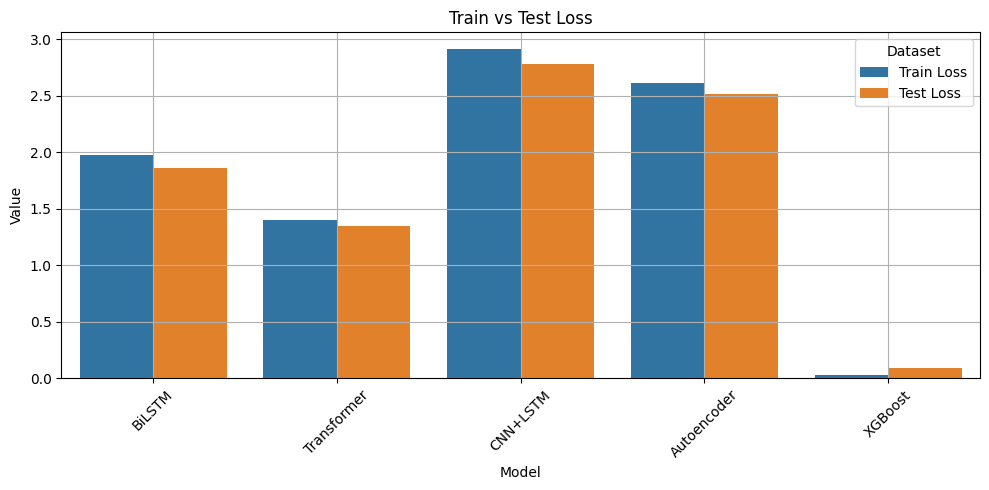

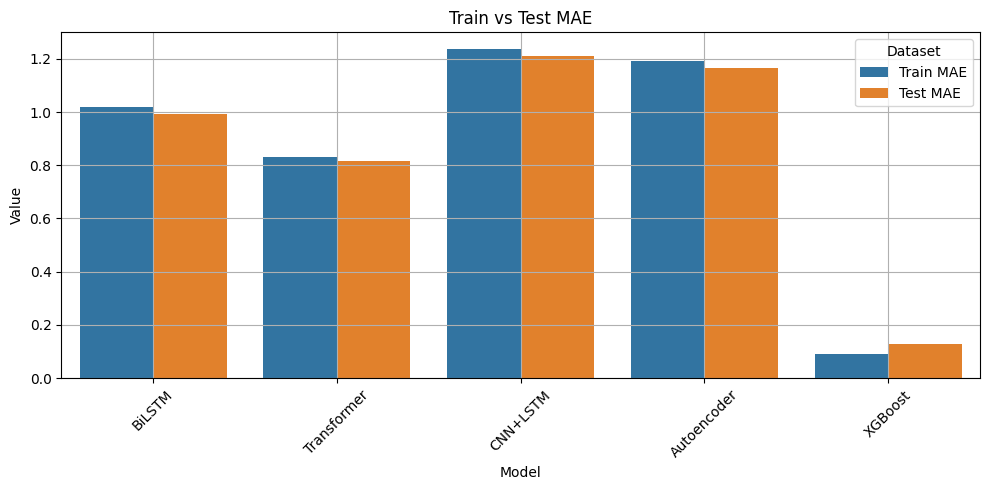

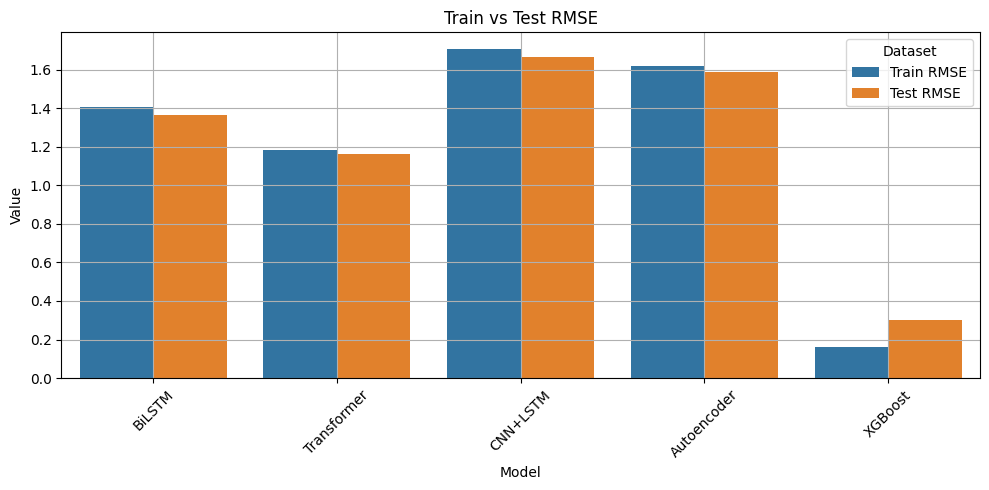

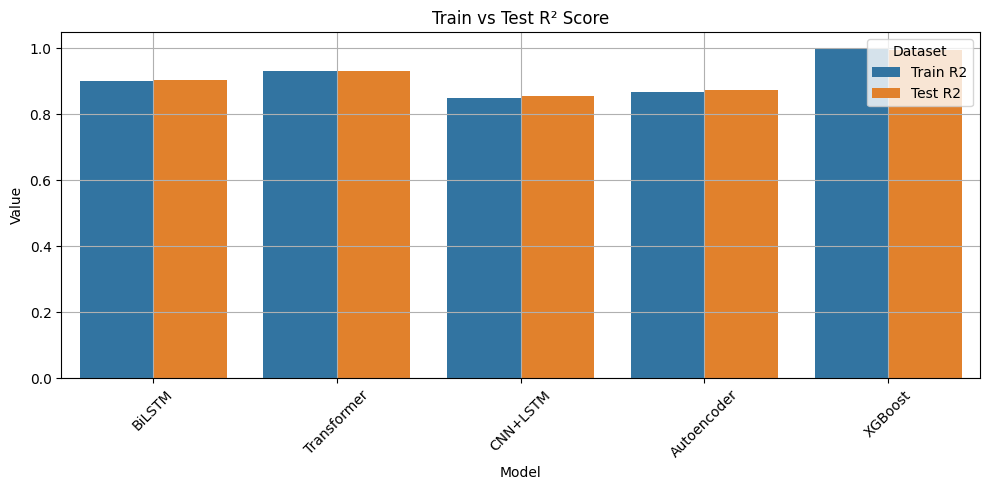

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert to DataFrame if not already
results_df = pd.DataFrame(results)

# Round for cleaner display
results_df_rounded = results_df.round(4)

# Plot function
def plot_metric_pair(df, train_metric, test_metric, title):
    melted_df = df[['Model', train_metric, test_metric]].melt(id_vars='Model', var_name='Dataset', value_name='Value')

    plt.figure(figsize=(10, 5))
    sns.barplot(data=melted_df, x='Model', y='Value', hue='Dataset')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# 🔢 Plotting all relevant metric pairs
plot_metric_pair(results_df_rounded, 'Train Loss', 'Test Loss', 'Train vs Test Loss')
plot_metric_pair(results_df_rounded, 'Train MAE', 'Test MAE', 'Train vs Test MAE')
plot_metric_pair(results_df_rounded, 'Train RMSE', 'Test RMSE', 'Train vs Test RMSE')
plot_metric_pair(results_df_rounded, 'Train R2', 'Test R2', 'Train vs Test R² Score')
